In [3]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Examines whether prior knowledge is a distractor in prediction tasks
"""
__author__ = ["Leo S. Rüdian"]
__copyright__ = "2024, Rüdian"
__credits__ = ["Leo S. Rüdian"]
__license__ = "Commons Clause"
__version__ = "1.0.0"
__maintainer__ = ["Leo S. Rüdian"]
__email__ =["ruediasy@informatik.hu-berlin.de"]
__status__ = "Experimental Setting"

import pandas
from sklearn.preprocessing import LabelEncoder, QuantileTransformer
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix,classification_report,mean_absolute_error
import seaborn as sn

# CSV file
file = "[insert file here].csv"

# add which group should be considered
cohort = 'advanced' # 'beginner/advanced'

#['PD','TH','GW','GA','CP']
step = 0 # [0-4]

# load dataset
dataset = pandas.read_csv(file,delimiter=";")

# filter, beginner = 1, advanced = 0
if cohort=='beginner': dataset = dataset[dataset['isnew']==1]
else: dataset = dataset[dataset['isnew']==0]

# remove identifier for prior knowledge
del dataset['isnew']

# remove sub items used to derive preferences
for el in ('pd1;pd2;th1;th2;gw1;gw2;ga1;ga2;cp1;cp2'.split(';')):
	 del dataset[el] 
        
data = dataset.values


C:\Users\Leo\AppData\Local\Programs\Python\Python39\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (5.1.0)/charset_normalizer (2.0.9) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [4]:
# separate data into input and output columns
X = data[:,0:105].astype(float)
Y = data[:,106:111].astype(float)

# select preference as demanded
y = Y[:,step:step+1].astype(float)

# perform a uniform quantile transform of the dataset
trans = QuantileTransformer(n_quantiles=7, output_distribution='uniform') # normal uniform
X = trans.fit_transform(X)

# Prepare label for visualization
y_label = []
for i in y.tolist(): 
    if not str(i[0]) in y_label: y_label.append(str(i[0]))
y_label.sort()

# Employ LDA to transform features to be separable
y_lda = LabelEncoder().fit_transform(y.astype('str'))
lda = LinearDiscriminantAnalysis(n_components=5) # adjust components if necessary
lda.fit(X,y_lda)
X = lda.transform(X)

# convert integers to dummy variables (i.e. one hot encoded)
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)
dummy_y = np_utils.to_categorical(encoded_Y)

# Splits for cross-validation
X2 = X
Y2 = dummy_y
splits = 5
acc_temp = 0
acc_temp_learn = 0
xlen = int(len(X2)/splits)+1
ylen = int(len(Y2)/splits)+1

y_true = []
y_pred = []

for split_pos in range(splits+1):
    if split_pos > 0:
        
        A = X2[:xlen*(split_pos -1)]
        A_y = Y2[:ylen*(split_pos -1)]
        Test_x = X2[xlen*(split_pos -1):xlen*(split_pos)]
        Test_y = Y2[ylen*(split_pos -1):ylen*(split_pos)]
        B = X2[xlen*(split_pos)+1:]
        B_y = Y2[xlen*(split_pos)+1:]

        X_train, Y_train = [],[]
        
        for i in A: X_train.append(i)
        for i in B: X_train.append(i)
        for i in A_y: Y_train.append(i)
        for i in B_y: Y_train.append(i)
        X_train = np.array(X_train)
        Y_train = np.array(Y_train)

        # model training
        model = RandomForestRegressor(random_state=5, max_depth=5,criterion="absolute_error")
        model.fit(X_train,Y_train)
        scores = model.score(Test_x, Test_y)
        
        # model evaluation
        hit, sums = 0, 0

        for i in range(len(Test_x)):
            pred = model.predict([Test_x[i]])
            true_y = np.argmax(Test_y[i])
            pred_y = np.argmax(pred)
            y_true.append(true_y)
            y_pred.append(pred_y)
            if true_y == pred_y: hit += 1
            sums += 1  
        
        acc = float(hit)/float(sums)
        acc_temp += acc

# Evaluation Metrics
test_mae = (mean_absolute_error(y_true, y_pred))
conf = confusion_matrix(y_true,y_pred)
classification_report_str = (classification_report(y_true, y_pred, target_names=y_label))

# Explained Variance Ratio of LDA components
EVR = lda.explained_variance_ratio_
sm = 0
for idx, R in enumerate(EVR):
    sm += np.round(R*100,2)

print('MAE',test_mae)
print('sum explained variance of LDA',sm)
print (conf)
print ('### Overall ###')
print("Acc: %.2f%%" % (acc_temp/splits*100))
print("Acc-Learn: %.2f%%" % (acc_temp_learn/splits*100))
print(classification_report_str)

C:\Users\Leo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Leo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Leo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


MAE 0.31868131868131866
sum explained variance of LDA 88.92000000000002
[[ 0  0  0  0  0  0  1  0]
 [ 0  4  0  1  0  0  0  0]
 [ 0  0 11  0  1  0  0  0]
 [ 0  0  0 16  0  0  1  0]
 [ 0  0  0  0 25  0  0  0]
 [ 0  0  2  0  0 13  1  0]
 [ 0  0  0  1  1  0  9  0]
 [ 0  0  0  1  0  0  0  3]]
### Overall ###
Acc: 88.63%
Acc-Learn: 0.00%
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         1.5       1.00      0.80      0.89         5
         2.0       0.85      0.92      0.88        12
         2.5       0.84      0.94      0.89        17
         3.0       0.93      1.00      0.96        25
         3.5       1.00      0.81      0.90        16
         4.0       0.75      0.82      0.78        11
         4.5       1.00      0.75      0.86         4

    accuracy                           0.89        91
   macro avg       0.80      0.75      0.77        91
weighted avg       0.89      0.89      0.89        91



C:\Users\Leo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Leo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Leo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

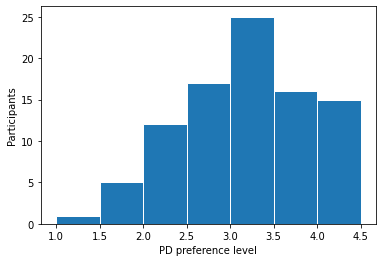

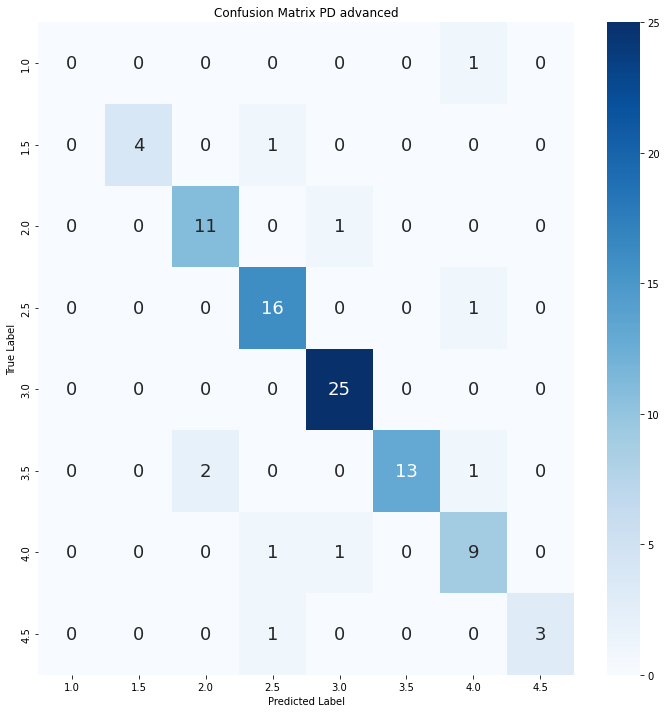

In [5]:
# plot Histogram
plt.hist(y,density=False, edgecolor='white',bins=list(map(float, y_label)))  # density=False would make counts
plt.ylabel('Participants')
plt.xlabel(['PD','TH','GW','GA','CP'][step]+' preference level');
plt.savefig('results/'+['PD','TH','GW','GA','CP'][step]+' '+cohort+'_hist.png',  dpi=300, transparent=True)
plt.show()

# plot Confusion Matrix
plt.figure(figsize=(12,12))
plt.title("Confusion Matrix "+['PD','TH','GW','GA','CP'][step]+' '+cohort)
plt.xlabel('Predicted Label')
plt.ylabel('True Label ')

df_cm = pandas.DataFrame(conf, index = [i for i in y_label],  columns = [i for i in y_label]) #,
s = sn.heatmap(df_cm, annot=True,cmap='Blues', annot_kws={"fontsize":18})#,ax=ax2)
s.set(xlabel='Predicted Label', ylabel='True Label')

plt.savefig('results/'+['PD','TH','GW','GA','CP'][step]+' '+cohort+'.png',  dpi=300, transparent=True)
plt.show()

# write report
with open('results/'+['PD','TH','GW','GA','CP'][step]+' '+cohort+'_report.txt', "w") as file1:
    file1.write("\t Evaluation (classification)\n"+classification_report_str+"\n")
    file1.write("\t Evaluation (regression)\n \t MAE:\t"+str(round(test_mae,2)))
    file1.write('\t LDA loss:\t'+str(round(1-sm/100,2))+"\n")
    file1.write('\t Explained Variance:\t'+str(round(sm/100,2))+"\n")